# Master matrix test
This is a notebook to quickly give you an idea of how your master matrix is performing; does it work the way that you expect?

In [14]:
# import necessary stuff
import mastermat
import matplotlib as mpl
import numpy as np
import scipy
from matplotlib import pyplot as plt
import imageio.v2 as imageio
import cv2

# can toggle between colormaps
# I prefer the aesthetic of 'inferno', but 'viridis' is more Inscopix-themed.
# mpl.rc('image', cmap='inferno')
mpl.rc('image', cmap='viridis')

## Tasks for the user, before running
Follow the steps below to prepare this notebook with the master matrix you want to test

The cell below contains the path to the master matrix we created before.

### Step 1: tell the notebook where to search for your mastermat
comment out the definition of `savepath`, replace it with the definition in `make_mastermat.py`.

In [2]:
# EDIT ME: comment out the line below.
savepath = ("../data/mastermat/row_inds_ringed_curved_normalized.npy", "../data/mastermat/col_inds_ringed_curved_normalized.npy","../data/mastermat/values_ringed_curved_normalized.npy")

# paste in the definition of savepath from the make_mastermat.py file below this comment:

### Step 2: run the notebook
Press the "restart and run all" button at the top of this window

## Preparatory Stuff
Instantiating the appropriate objects; the cell immediately below this loads the CSR arrays from disk, which takes some time.

In [3]:
row_inds_csr, col_inds_csr, values_csr = mastermat.load_csr_files(csr_paths=savepath)

Print the number of nonzero values:

In [4]:
values_csr.shape

(1624134070,)

In [6]:
# need to expand the row indices-array, since this is the format that's required by scipy
# specifically, we just repeat the last index value over and over again
row_inds_csr_expanded = np.empty(1024001)
row_inds_csr_expanded[:row_inds_csr.shape[0]] = row_inds_csr
row_inds_csr_expanded[row_inds_csr.shape[0]:] = row_inds_csr[-1]

Create a CSR object in memory from the row indices, column indices and values that we loaded before.
This is just an object with a `dot()` method that performs the matrix multiplication, which is what we use for simulating images.

In [7]:
mastermat_csr = scipy.sparse.csr_matrix((values_csr, col_inds_csr, row_inds_csr_expanded), shape=(1024000, 1024000))

# Actual image simulation examples

## Simulating an image of ones

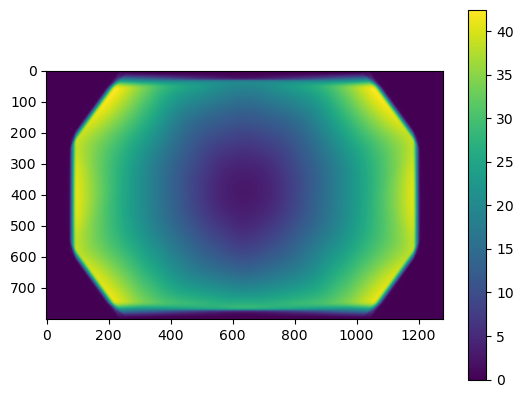

In [10]:
plt.imshow(mastermat.simulate_image(np.ones((800,1280)), mastermat_csr))
plt.colorbar()

## Simulating a real image from the Waller et al dataset

Text(0.5, 1.0, 'simulated image')

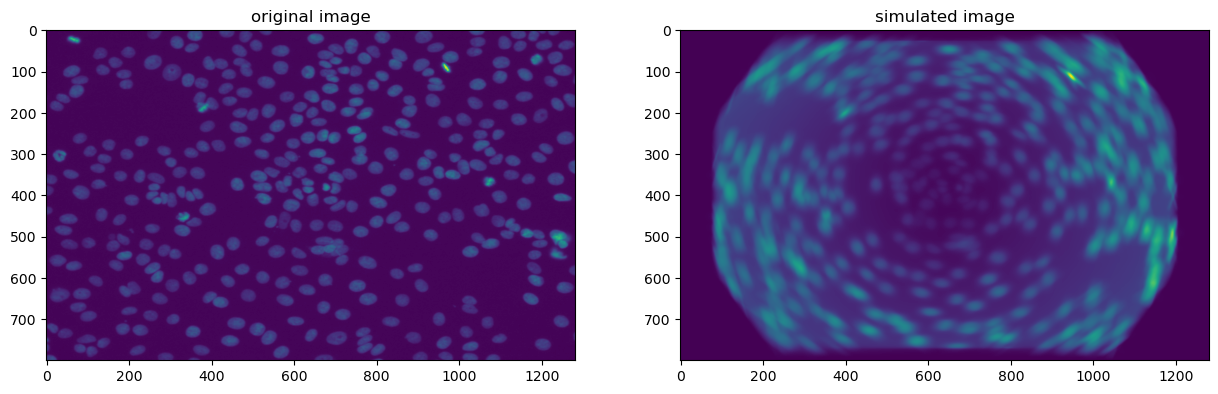

In [15]:
# load an image, simulate what it looks like through nVista, display both
img = imageio.imread("../data/nV3_resized/1.png")
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(img)
axs[0].set_title("original image")

axs[1].imshow(mastermat.simulate_image(img, mastermat_csr))
axs[1].set_title("simulated image")

## Simulating the iconic dots image
First, we'll define a function that generates these dots. Then, we'll simulate what the grid of dots looks like through the microscope.

In [24]:
# below are two function definitions for drawing a grid of circles.
# you don't have to worry about them at all. If you choose to worry, the code speaks for itself.
# define a function that draws a circle
def draw_circle(radius):
    canvas = np.zeros((2*np.ceil(radius).astype(int), 2*np.ceil(radius).astype(int)))
    Xq, Yq = np.meshgrid(np.arange(radius*2), np.arange(radius*2))
    rad_to_point = (Xq - radius)**2 + (Yq - radius)**2
    canvas = rad_to_point < radius**2
    return canvas

# define a function that generates a grid of circles
def grid_of_circles(r, num_x, num_y, img_dims=(800,1280)):
    circle_obj = np.zeros(img_dims)
    for circ_row in range(1,num_y):
        for circ_col in range(1,num_x):
            circ_center = (circ_row*img_dims[0]//num_y, circ_col*img_dims[1]//num_x)
            circle_drawing = draw_circle(r)
            circle_obj[circ_center[0]-np.floor(circle_drawing.shape[0]/2).astype(int)\
                       :circ_center[0]+np.ceil(circle_drawing.shape[0]/2).astype(int), \
                       circ_center[1]-np.floor(circle_drawing.shape[1]/2).astype(int)\
                       :circ_center[1]+np.ceil(circle_drawing.shape[1]/2).astype(int)] = circle_drawing
    return circle_obj

We want to simulate a grid of 3 $\mu$m-diameter beads. 3 $\mu$m is equivalent to 3.75 pixels, since the pixels are spaced 0.8 $\mu$m apart:

Text(0.5, 1.0, 'simulated image of 3-um beads')

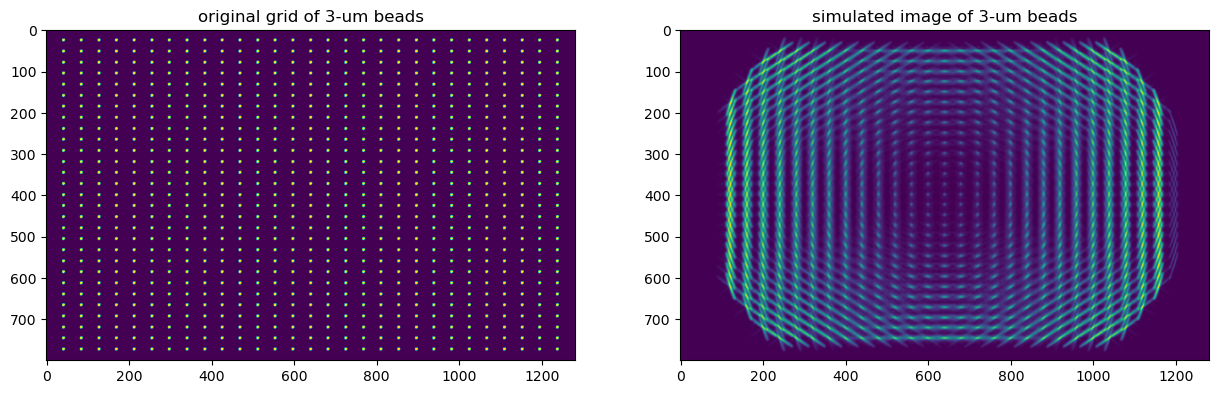

In [25]:
# we want to generate a 30-by-30 grid of 3-um beads
circle_obj = grid_of_circles(3.75, 30, 30, img_dims=(800,1280))

# now, we want to plot the original side-by-side with the simulated image
fig, axs = plt.subplots(1, 2, figsize=(15,15))
axs[0].imshow(circle_obj)
axs[0].set_title("original grid of 3-um beads")

axs[1].imshow(mastermat.simulate_image(circle_obj, mastermat_csr))
axs[1].set_title("simulated image of 3-um beads")